In [1]:
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
import pickle

from SSD300.ssd_v2 import SSD300v2
from SSD300.ssd_training import MultiboxLoss
from SSD300.ssd_utils import BBoxUtility

from get_data_from_XML import XML_preprocessor
from generator import Generator

NUM_CLASSES = 21 # 实际上只有20个class
input_shape = (300, 300, 3)

model = SSD300v2(input_shape, num_classes=NUM_CLASSES)

loss = MultiboxLoss(NUM_CLASSES, neg_pos_ratio=2.0).compute_loss
model.compile(optimizer='Adadelta', loss=loss)

# model.summary()

Using TensorFlow backend.


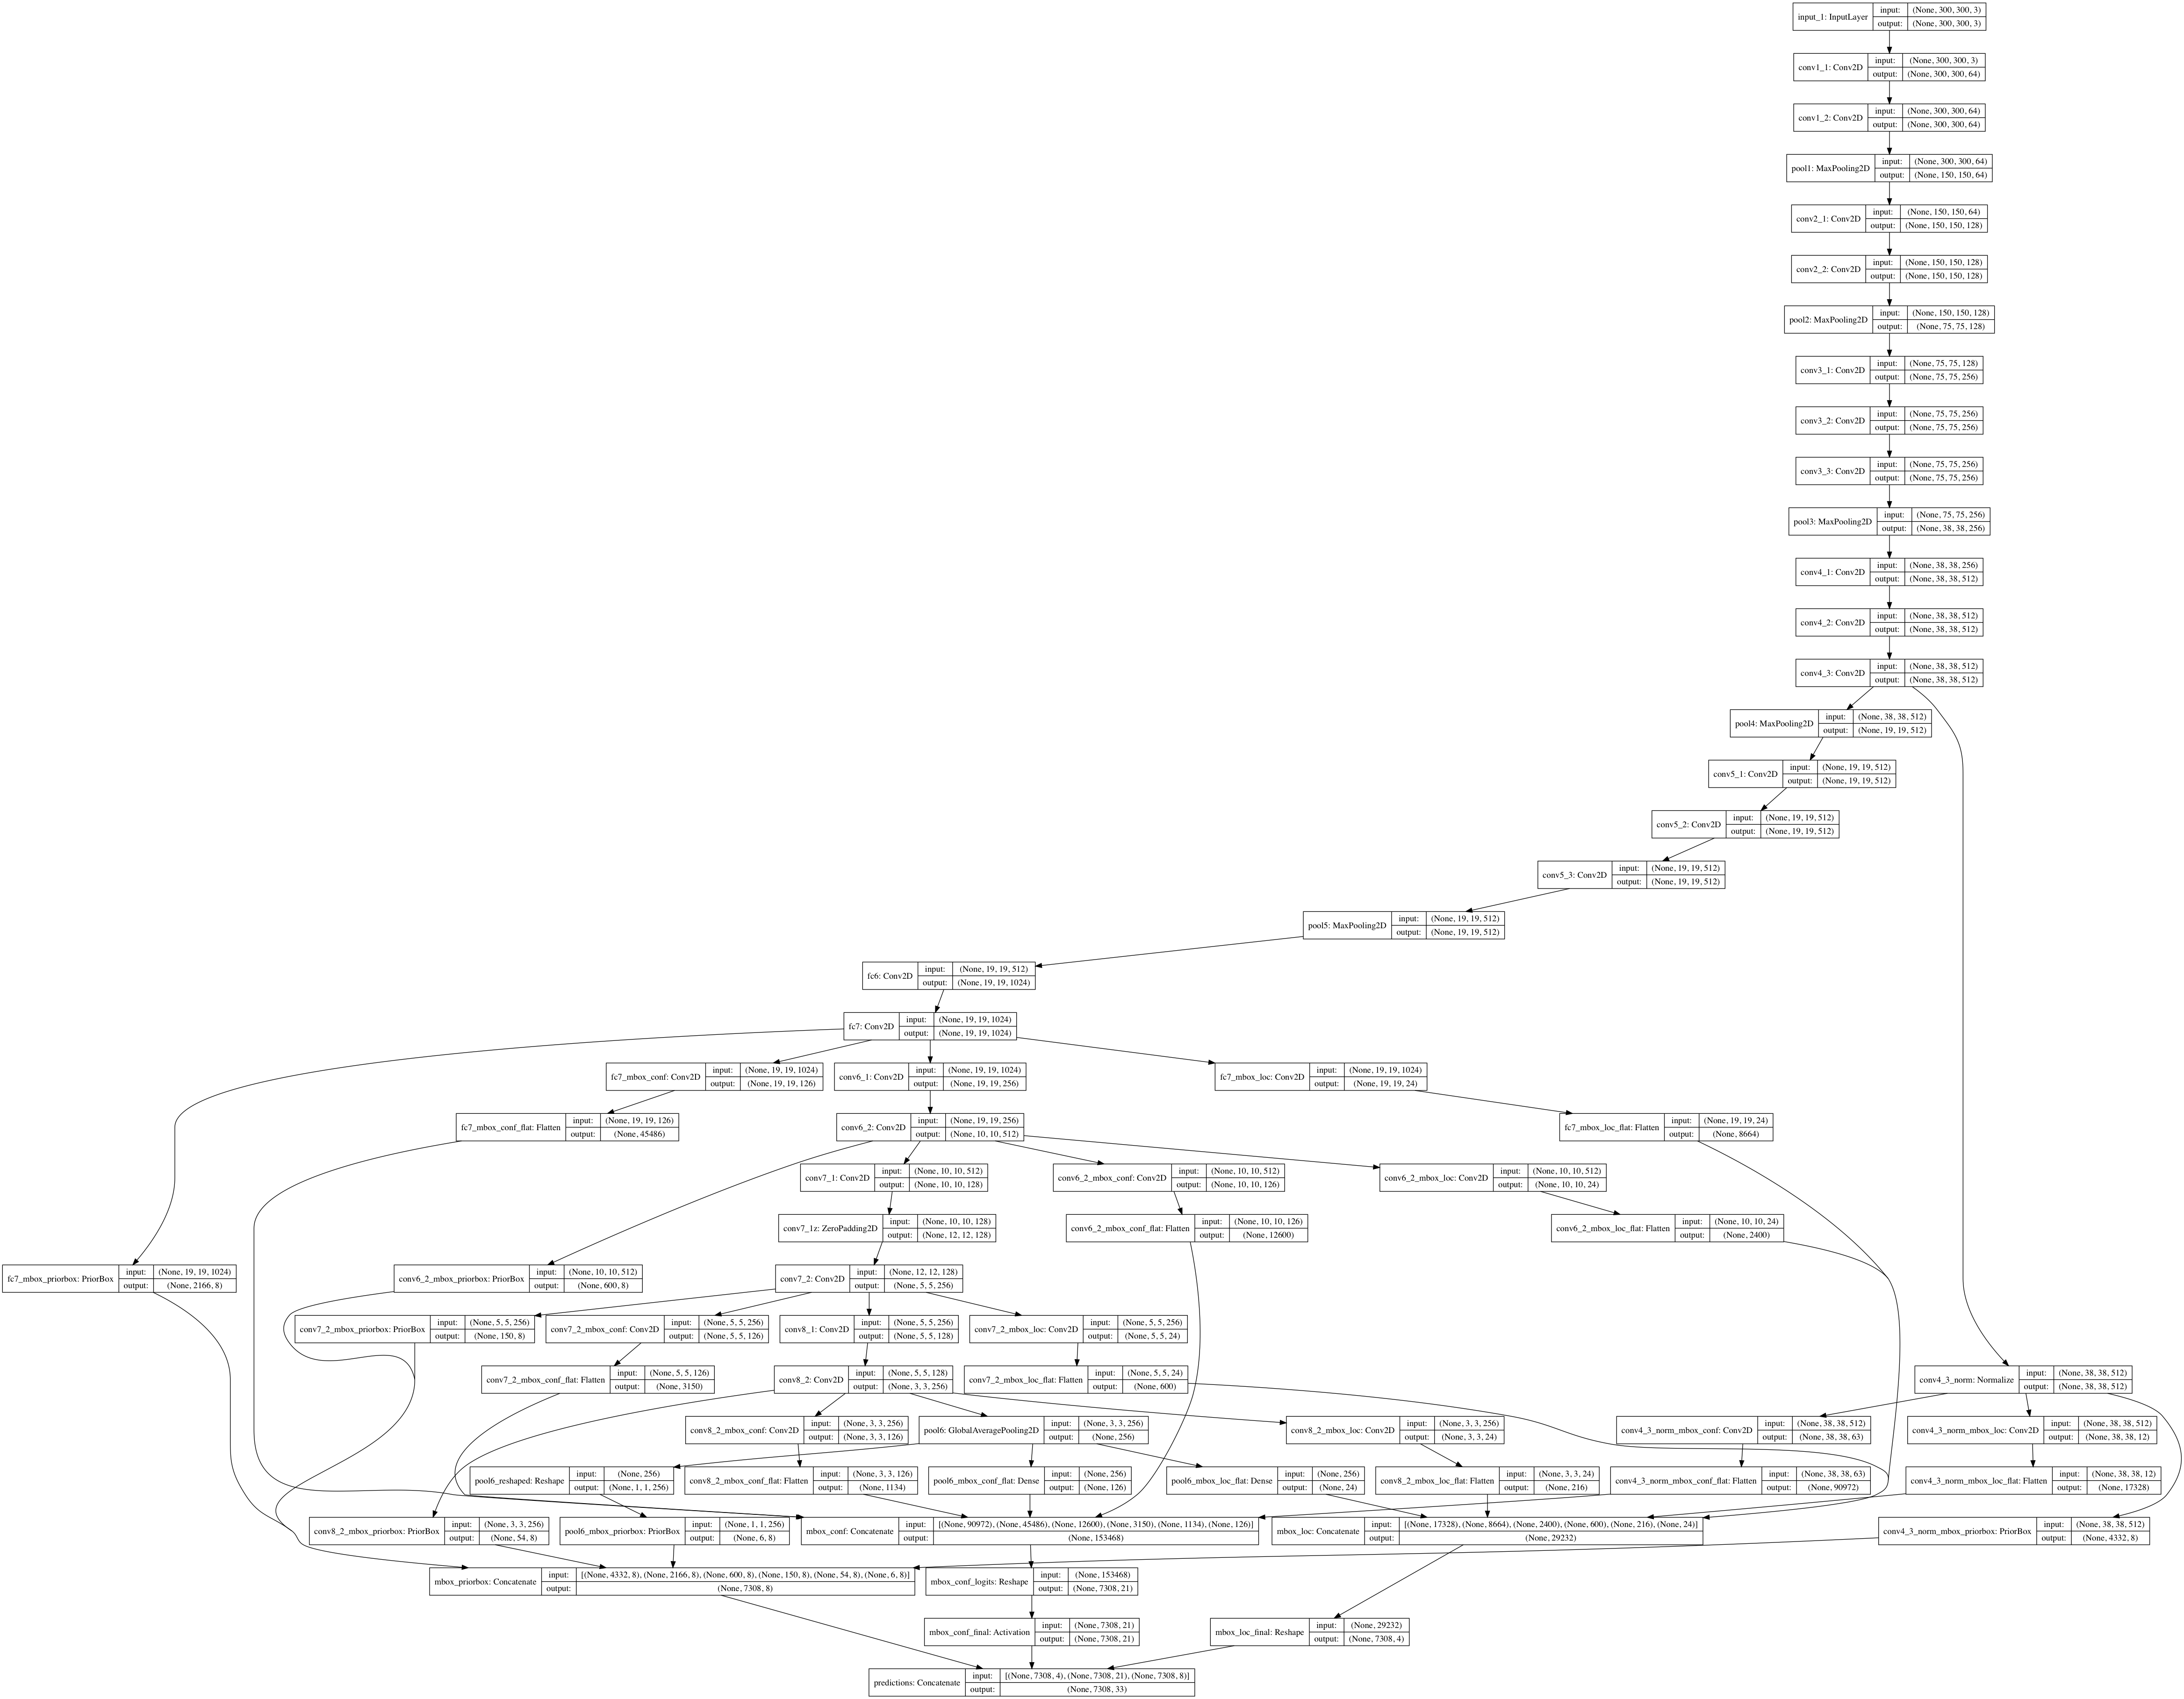

In [4]:
from keras.utils.vis_utils import plot_model
from IPython.display import Image
plot_model(model, to_file="./assets/model.png", show_shapes=True)
Image('./assets/model.png')

In [5]:
priors = pickle.load(open('./SSD300/prior_boxes_ssd300.pkl', 'rb'))
bbox_util = BBoxUtility(NUM_CLASSES, priors)

In [6]:
pascal_voc_07_parser = XML_preprocessor(data_path='./VOCdevkit/VOC2007/Annotations/')
# len(pascal_voc_07_parser.data) = 5011

# pascal_voc_07_parser.data['000007.jpg']
# array([[ 0.282     ,  0.15015015,  1.        ,  0.99099099,  0.        ,
#          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
#          1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
#          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
#          0.        ,  0.        ,  0.        ,  0.        ]])

keys = list(pascal_voc_07_parser.data.keys())
train_num = int(0.7 * len(keys))
train_keys = keys[:train_num]
val_keys = keys[train_num:]

gen = Generator(gt=pascal_voc_07_parser.data, bbox_util=bbox_util,
                 batch_size=16, path_prefix='./VOCdevkit/VOC2007/JPEGImages/',
                 train_keys=train_keys, val_keys=val_keys, image_size=(300, 300))

In [ ]:
RUN = RUN + 1 if 'RUN' in locals() else 1

LOG_DIR = './output/training_logs/run{}'.format(RUN)
LOG_FILE_PATH = LOG_DIR + '/checkpoint-{epoch:02d}-{val_loss:.4f}.hdf5'

EPOCHS = 1
STEPS_PER_EPOCH = 512

tensorboard = TensorBoard(log_dir=LOG_DIR, write_images=True)
checkpoint = ModelCheckpoint(filepath=LOG_FILE_PATH, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

history = model.fit_generator(generator=gen.generate(True), steps_per_epoch=gen.train_batches,
                              validation_data=gen.generate(False), validation_steps=gen.val_batches,
                              epochs=EPOCHS, verbose=1, callbacks=[tensorboard, checkpoint, early_stopping])